### 1. Load up datasets for 3 months
This project will be using the first quarter 2024 data. 

In [1]:
# Load parquet file into dataframe
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import dask.dataframe as dd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from lightgbm import LGBMRegressor
import xgboost as xgb
import gc
import pickle

Reuseable function to load required columns from parquet file

In [2]:
# Load file and ensure columns are in format to ease processing
def process_parquet(parquet_file_path, sample_frac=0.005):
    columns_needed = ['request_datetime', 'on_scene_datetime', 'PULocationID', 'DOLocationID', 'trip_time']

    # Read the specific columns
    df = pd.read_parquet(parquet_file_path, columns=columns_needed)
    
    # Sample a fraction of the dataframe to reduce memory usage and make processing faster
    sampled_df = df.sample(frac=sample_frac)
    
    # Convert datetime columns
    sampled_df['request_datetime'] = pd.to_datetime(sampled_df['request_datetime'])
    sampled_df['on_scene_datetime'] = pd.to_datetime(sampled_df['on_scene_datetime'])

    # Convert to second precision to save memory
    sampled_df['request_datetime'] = sampled_df['request_datetime'].values.astype('datetime64[s]')
    sampled_df['on_scene_datetime'] = sampled_df['on_scene_datetime'].values.astype('datetime64[s]')

    # Convert int64 to int32
    sampled_df['trip_time'] = sampled_df['trip_time'].astype('int32')
    
    # Calculate the wait_time in seconds
    sampled_df['wait_time'] = (sampled_df['on_scene_datetime'] - sampled_df['request_datetime']).dt.total_seconds()
    sampled_df['wait_time'] = sampled_df['wait_time'].astype('float32')
    
    return sampled_df

In [3]:
# Jan 2024
trip_jan = process_parquet('data/fhvhv_tripdata_2024-01.parquet')
trip_jan.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
7099341,2024-01-13 00:18:47,2024-01-13 00:21:46,37,61,1052,179.0
9982408,2024-01-17 12:46:01,2024-01-17 12:50:25,235,265,2123,264.0
4183072,2024-01-08 07:23:33,NaT,226,146,519,NaN
774863,2024-01-02 09:49:11,NaT,112,34,1502,NaN
16970228,2024-01-27 18:02:16,2024-01-27 18:09:35,141,164,1219,439.0


In [4]:
# Feb 2024
trip_feb = process_parquet('data/fhvhv_tripdata_2024-02.parquet') 
trip_feb.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
16343563,2024-02-25 10:06:53,2024-02-25 10:08:51,178,37,2056,118.0
17480637,2024-02-27 08:31:30,2024-02-27 08:33:06,133,181,535,96.0
13846747,2024-02-21 21:26:16,2024-02-21 21:43:10,263,112,1514,1014.0
2253077,2024-02-04 02:22:19,NaT,79,107,438,NaN
15317762,2024-02-24 00:57:05,NaT,61,188,531,NaN


In [5]:
# Mar 2024
trip_mar = process_parquet('data/fhvhv_tripdata_2024-03.parquet') 
trip_mar.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
20586132,2024-03-30 23:32:04,NaT,79,90,835,NaN
379973,2024-03-01 15:21:27,2024-03-01 15:25:54,241,235,893,267.0
17356524,2024-03-26 09:50:30,2024-03-26 09:51:12,138,173,958,42.0
11769256,2024-03-17 19:59:57,NaT,257,188,808,NaN
11897453,2024-03-18 04:38:36,2024-03-18 04:47:39,166,151,431,543.0


In [6]:
# Merge the three dataframes, ensure the merge is optimised
trips = pd.concat([trip_jan, trip_feb, trip_mar], ignore_index=True)

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
0,2024-01-13 00:18:47,2024-01-13 00:21:46,37,61,1052,179.0
1,2024-01-17 12:46:01,2024-01-17 12:50:25,235,265,2123,264.0
2,2024-01-08 07:23:33,NaT,226,146,519,NaN
3,2024-01-02 09:49:11,NaT,112,34,1502,NaN
4,2024-01-27 18:02:16,2024-01-27 18:09:35,141,164,1219,439.0


In [7]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301520 entries, 0 to 301519
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   301520 non-null  datetime64[s]
 1   on_scene_datetime  222932 non-null  datetime64[s]
 2   PULocationID       301520 non-null  int32        
 3   DOLocationID       301520 non-null  int32        
 4   trip_time          301520 non-null  int32        
 5   wait_time          222932 non-null  float32      
dtypes: datetime64[s](2), float32(1), int32(3)
memory usage: 9.2 MB


### 2. Data Exploration

In [8]:
# Shape of dataframe
trips.shape

(301520, 6)

In [9]:
trips.describe()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
count,301520,222932,301520.000000,301520.000000,301520.000000,222932.000000
mean,2024-02-16 10:58:26,2024-02-16 13:28:56,138.652554,142.035812,1149.425322,191.692841
min,2023-12-31 23:49:24,2024-01-01 00:01:10,3.000000,1.000000,1.000000,-4078.000000
25%,2024-01-24 23:52:29,2024-01-25 08:49:45,75.000000,76.000000,584.000000,97.000000
50%,2024-02-16 17:42:39,2024-02-16 17:02:00,140.000000,141.000000,939.000000,163.000000
75%,2024-03-09 18:11:21,2024-03-09 19:58:45,210.000000,216.000000,1482.000000,259.000000
max,2024-03-31 23:57:16,2024-03-31 23:59:16,265.000000,265.000000,34644.000000,4798.000000
std,NaN,NaN,74.938178,77.731744,810.971699,190.056503


In [10]:
# Check for nulls
trips.isnull().sum()

request_datetime         0
on_scene_datetime    78588
PULocationID             0
DOLocationID             0
trip_time                0
wait_time            78588
dtype: int64

In [11]:
# Drop nulls there is more than enough data
trips = trips.dropna()
trips.shape

(222932, 6)

<Axes: xlabel='wait_time'>

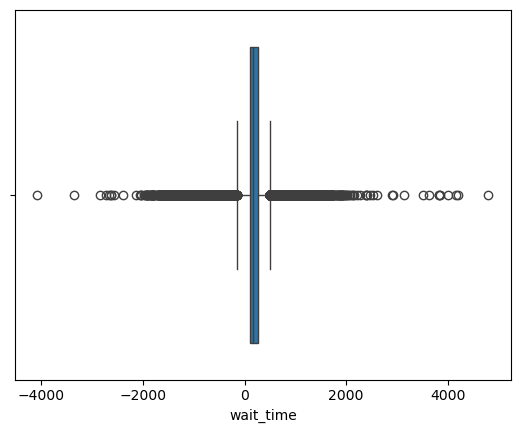

In [12]:
# Wait time seems to have some negative values from the min. Using boxplot to investigate more
sns.boxplot(x=trips['wait_time'])

In [13]:
# Get the count of negative wait times.
trips[trips['wait_time'] < 0]['wait_time'].count()

2005

In [14]:
# Drop negative wait times
trips = trips[trips['wait_time'] >= 0]

trips.shape

(220927, 6)

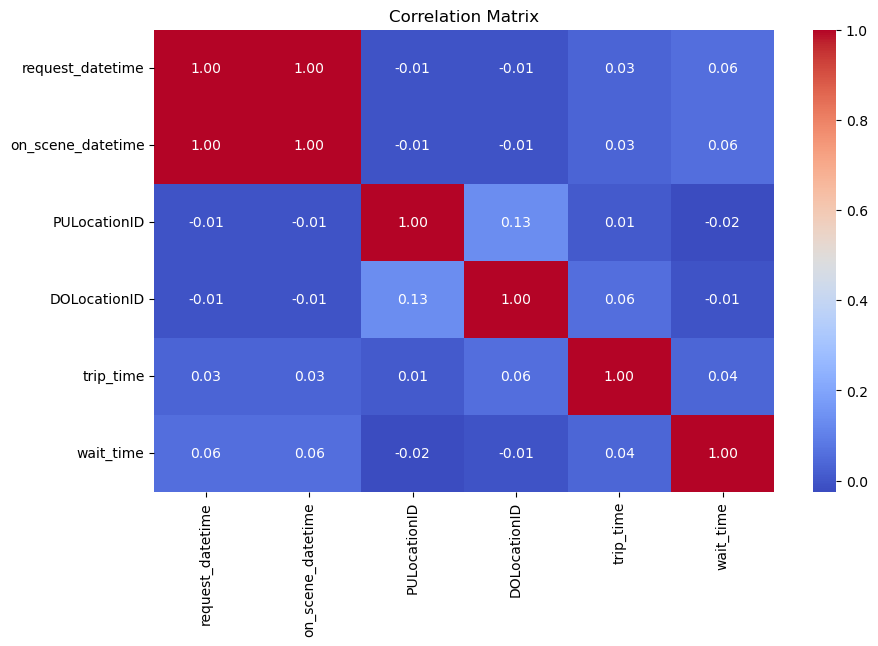

In [15]:
# understand the relationship between variables
plt.figure(figsize=(10, 6))
sns.heatmap(trips.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### 3. Add external data and features
#### 3.1. Add Holidays in NYC data

In [16]:
# Holidays
from datetime import date
import holidays

ny_holidays = holidays.country_holidays('US', subdiv='NY', years=2024)

# Load ny_holidays into dataframe, date and holiday name
ny_holidays_df = pd.DataFrame.from_dict(ny_holidays, orient='index')
ny_holidays_df

,0
2024-01-01,New Year's Day
2024-05-27,Memorial Day
2024-06-19,Juneteenth National Independence Day
2024-07-04,Independence Day
2024-09-02,Labor Day
2024-11-11,Veterans Day
2024-11-28,Thanksgiving
2024-12-25,Christmas Day
2024-01-15,Martin Luther King Jr. Day
2024-02-19,Washington's Birthday


In [17]:
# Reset index and rename columns
ny_holidays_df.reset_index(inplace=True)
ny_holidays_df.columns = ['date', 'holiday_name']
ny_holidays_df

,date,holiday_name
0,2024-01-01,New Year's Day
1,2024-05-27,Memorial Day
2,2024-06-19,Juneteenth National Independence Day
3,2024-07-04,Independence Day
4,2024-09-02,Labor Day
5,2024-11-11,Veterans Day
6,2024-11-28,Thanksgiving
7,2024-12-25,Christmas Day
8,2024-01-15,Martin Luther King Jr. Day
9,2024-02-19,Washington's Birthday


In [18]:
# Convert holidays to datetime and create is_holiday flag in the trips dataframe
ny_holidays_df.index = pd.to_datetime(ny_holidays_df.index)
ny_holidays_df['date'].values.astype('datetime64[s]')
trips['is_holiday'] = trips['request_datetime'].dt.date.isin(ny_holidays_df['date']).astype(int)
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday
0,2024-01-13 00:18:47,2024-01-13 00:21:46,37,61,1052,179.0,0
1,2024-01-17 12:46:01,2024-01-17 12:50:25,235,265,2123,264.0,0
4,2024-01-27 18:02:16,2024-01-27 18:09:35,141,164,1219,439.0,0
5,2024-01-22 11:22:53,2024-01-22 11:25:35,113,211,318,162.0,0
7,2024-01-31 21:57:03,2024-01-31 22:00:20,65,148,566,197.0,0


In [19]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220927 entries, 0 to 301518
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   220927 non-null  datetime64[s]
 1   on_scene_datetime  220927 non-null  datetime64[s]
 2   PULocationID       220927 non-null  int32        
 3   DOLocationID       220927 non-null  int32        
 4   trip_time          220927 non-null  int32        
 5   wait_time          220927 non-null  float32      
 6   is_holiday         220927 non-null  int64        
dtypes: datetime64[s](2), float32(1), int32(3), int64(1)
memory usage: 10.1 MB


#### 3.2. Add Time Based Features

In [20]:
# Hour of the day, day of the week, month, year
trips['hour'] = trips['request_datetime'].dt.hour
trips['week_day'] = trips['request_datetime'].dt.weekday
trips['week_number'] = trips['request_datetime'].dt.isocalendar().week
trips['month'] = trips['request_datetime'].dt.month

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month
0,2024-01-13 00:18:47,2024-01-13 00:21:46,37,61,1052,179.0,0,0,5,2,1
1,2024-01-17 12:46:01,2024-01-17 12:50:25,235,265,2123,264.0,0,12,2,3,1
4,2024-01-27 18:02:16,2024-01-27 18:09:35,141,164,1219,439.0,0,18,5,4,1
5,2024-01-22 11:22:53,2024-01-22 11:25:35,113,211,318,162.0,0,11,0,4,1
7,2024-01-31 21:57:03,2024-01-31 22:00:20,65,148,566,197.0,0,21,2,5,1


In [21]:
# Define total trip time
trips['total_trip_time'] = trips['wait_time'] + trips['trip_time']
trips['total_trip_time'] = trips['total_trip_time'].astype('float32')
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month,total_trip_time
0,2024-01-13 00:18:47,2024-01-13 00:21:46,37,61,1052,179.0,0,0,5,2,1,1231.0
1,2024-01-17 12:46:01,2024-01-17 12:50:25,235,265,2123,264.0,0,12,2,3,1,2387.0
4,2024-01-27 18:02:16,2024-01-27 18:09:35,141,164,1219,439.0,0,18,5,4,1,1658.0
5,2024-01-22 11:22:53,2024-01-22 11:25:35,113,211,318,162.0,0,11,0,4,1,480.0
7,2024-01-31 21:57:03,2024-01-31 22:00:20,65,148,566,197.0,0,21,2,5,1,763.0


In [22]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220927 entries, 0 to 301518
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   220927 non-null  datetime64[s]
 1   on_scene_datetime  220927 non-null  datetime64[s]
 2   PULocationID       220927 non-null  int32        
 3   DOLocationID       220927 non-null  int32        
 4   trip_time          220927 non-null  int32        
 5   wait_time          220927 non-null  float32      
 6   is_holiday         220927 non-null  int64        
 7   hour               220927 non-null  int32        
 8   week_day           220927 non-null  int32        
 9   week_number        220927 non-null  UInt32       
 10  month              220927 non-null  int32        
 11  total_trip_time    220927 non-null  float32      
dtypes: UInt32(1), datetime64[s](2), float32(2), int32(6), int64(1)
memory usage: 14.5 MB


#### 3.3. Group into Peak, off-peak and night time

In [23]:
""" 
    Group request datetime into Peak, Off-Peak and Night
    Night: 10pm to 6am
    Off-Peak: Weekdays, 10am to 3pm and 7pm to 10pm. Weekends, 6am to 10pm
    Peak: Weekdays, 6am to 10am and 3pm to 7pm
"""

# Extract hour and day of week
hour = trips['hour']
week_day = trips['week_day']

# is holiday
is_holiday = trips['is_holiday'].astype(bool)

# Initialize the default group as Night (0)
trips['request_time_group'] = 0

# Define conditions for Peak (2) and OffPeak (1) times for weekday
weekday_mask = week_day < 5

peak_mask = (hour >= 6) & (hour < 10) | (hour >= 15) & (hour < 19)
off_peak_mask = (hour >= 10) & (hour < 15) | (hour >= 19) & (hour < 22)

# For weekend
weekend_mask = ~weekday_mask

# Apply conditions for weekdays
# Pandas is built to work efficiently with data in a vectorized way, meaning it can operate on entire columns (or Series) of data at once without needing an explicit loop
# .loc leverages the underlying numpy array to apply the mask to the dataframe without iterating over rows one by one
# note that all day during holidays are Off-Peak

# If day is not holiday, it will be Peak
trips.loc[weekday_mask & peak_mask & ~is_holiday, 'request_time_group'] = 2
# If day is holiday, it will be Off-Peak
trips.loc[weekday_mask & peak_mask & is_holiday, 'request_time_group'] = 1

trips.loc[weekday_mask & off_peak_mask, 'request_time_group'] = 1

# Apply conditions for weekends
trips.loc[weekend_mask & (hour >= 6) & (hour < 22), 'request_time_group'] = 1

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month,total_trip_time,request_time_group
0,2024-01-13 00:18:47,2024-01-13 00:21:46,37,61,1052,179.0,0,0,5,2,1,1231.0,0
1,2024-01-17 12:46:01,2024-01-17 12:50:25,235,265,2123,264.0,0,12,2,3,1,2387.0,1
4,2024-01-27 18:02:16,2024-01-27 18:09:35,141,164,1219,439.0,0,18,5,4,1,1658.0,1
5,2024-01-22 11:22:53,2024-01-22 11:25:35,113,211,318,162.0,0,11,0,4,1,480.0,1
7,2024-01-31 21:57:03,2024-01-31 22:00:20,65,148,566,197.0,0,21,2,5,1,763.0,1


In [24]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220927 entries, 0 to 301518
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   request_datetime    220927 non-null  datetime64[s]
 1   on_scene_datetime   220927 non-null  datetime64[s]
 2   PULocationID        220927 non-null  int32        
 3   DOLocationID        220927 non-null  int32        
 4   trip_time           220927 non-null  int32        
 5   wait_time           220927 non-null  float32      
 6   is_holiday          220927 non-null  int64        
 7   hour                220927 non-null  int32        
 8   week_day            220927 non-null  int32        
 9   week_number         220927 non-null  UInt32       
 10  month               220927 non-null  int32        
 11  total_trip_time     220927 non-null  float32      
 12  request_time_group  220927 non-null  int64        
dtypes: UInt32(1), datetime64[s](2), float32(2), int32

In [25]:
# Drop unneeded columns
trips.drop(['on_scene_datetime'], axis=1, inplace=True)

trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month,total_trip_time,request_time_group
0,2024-01-13 00:18:47,37,61,1052,179.0,0,0,5,2,1,1231.0,0
1,2024-01-17 12:46:01,235,265,2123,264.0,0,12,2,3,1,2387.0,1
4,2024-01-27 18:02:16,141,164,1219,439.0,0,18,5,4,1,1658.0,1
5,2024-01-22 11:22:53,113,211,318,162.0,0,11,0,4,1,480.0,1
7,2024-01-31 21:57:03,65,148,566,197.0,0,21,2,5,1,763.0,1


In [26]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220927 entries, 0 to 301518
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   request_datetime    220927 non-null  datetime64[s]
 1   PULocationID        220927 non-null  int32        
 2   DOLocationID        220927 non-null  int32        
 3   trip_time           220927 non-null  int32        
 4   wait_time           220927 non-null  float32      
 5   is_holiday          220927 non-null  int64        
 6   hour                220927 non-null  int32        
 7   week_day            220927 non-null  int32        
 8   week_number         220927 non-null  UInt32       
 9   month               220927 non-null  int32        
 10  total_trip_time     220927 non-null  float32      
 11  request_time_group  220927 non-null  int64        
dtypes: UInt32(1), datetime64[s](1), float32(2), int32(6), int64(2)
memory usage: 14.5 MB


#### 3.4. NYC weather

In [27]:
# Get Weather data
from datetime import datetime 
from meteostat import Point, Hourly, units  
# Set time period 
start = datetime(2024, 1, 1) 
end = datetime(2024, 3, 31)  
# Create Point for NY
location = Point(40.712775, -74.005973)  
# Get daily data 
weather_data = Hourly(location, start, end) 
weather_data = weather_data.convert(units.imperial) 
weather_data = weather_data.fetch()

weather_data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [28]:
# Reset index and convert time to datetime
weather_data.reset_index(inplace=True)
weather_data.rename(columns={'index': 'time'}, inplace=True)
weather_data['time'] = pd.to_datetime(weather_data['time'])

weather_data.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
1,2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2,2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
3,2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
4,2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [29]:
# Create column to compare with weather time
trips['rounded_request_datetime'] = trips['request_datetime'].dt.round('H')

In [30]:
# Merge trips and weather dataframe on trips[rounded_request_datetime] and weather[time]
trips = trips.merge(weather_data, left_on='rounded_request_datetime', right_on='time', how='left')
trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-13 00:18:47,37,61,1052,179.0,0,0,5,2,1,...,37.9,76.0,0.0,NaN,80.0,7.0,NaN,1013.0,NaN,3.0
1,2024-01-17 12:46:01,235,265,2123,264.0,0,12,2,3,1,...,15.1,71.0,0.0,NaN,270.0,11.4,NaN,1016.5,NaN,1.0
2,2024-01-27 18:02:16,141,164,1219,439.0,0,18,5,4,1,...,37.9,73.0,0.0,NaN,3.0,5.8,NaN,1023.2,NaN,3.0
3,2024-01-22 11:22:53,113,211,318,162.0,0,11,0,4,1,...,17.1,66.0,0.0,NaN,250.0,7.0,NaN,1034.8,NaN,1.0
4,2024-01-31 21:57:03,65,148,566,197.0,0,21,2,5,1,...,31.1,76.0,0.0,NaN,260.0,4.7,NaN,1019.8,NaN,3.0


In [31]:
# Remove unneeded columns
trips.drop(['request_datetime', 'rounded_request_datetime', 'trip_time', 'wait_time', 'time', 'dwpt', 'rhum', 'prcp','snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'temp'], axis=1, inplace=True)

In [32]:
# Change data types
trips['request_time_group'] = trips['request_time_group'].astype('int32')
trips['coco'] = trips['coco'].astype('float32')

# Rename coco to weather_condition_code  
trips.rename(columns={'coco': 'weather_condition_code'}, inplace=True)

In [33]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220927 entries, 0 to 220926
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   PULocationID            220927 non-null  int32  
 1   DOLocationID            220927 non-null  int32  
 2   is_holiday              220927 non-null  int64  
 3   hour                    220927 non-null  int32  
 4   week_day                220927 non-null  int32  
 5   week_number             220927 non-null  UInt32 
 6   month                   220927 non-null  int32  
 7   total_trip_time         220927 non-null  float32
 8   request_time_group      220927 non-null  int32  
 9   weather_condition_code  218572 non-null  float32
dtypes: UInt32(1), float32(2), int32(6), int64(1)
memory usage: 9.5 MB


In [34]:
# Check for null values
trips.isnull().sum()

PULocationID                 0
DOLocationID                 0
is_holiday                   0
hour                         0
week_day                     0
week_number                  0
month                        0
total_trip_time              0
request_time_group           0
weather_condition_code    2355
dtype: int64

In [35]:
# Drop null values
trips.dropna(inplace=True)

In [36]:
# Check for null values
trips.isnull().sum()

PULocationID              0
DOLocationID              0
is_holiday                0
hour                      0
week_day                  0
week_number               0
month                     0
total_trip_time           0
request_time_group        0
weather_condition_code    0
dtype: int64

In [37]:
# Check dataset shape
trips.shape

(218572, 10)

### 4. More EDA - Investigating features

In [38]:
#rounding up columns and converting to int32
trips['total_trip_time'] = np.ceil(trips['total_trip_time']).astype('int32')
trips['weather_condition_code'] = np.ceil(trips['weather_condition_code']).astype('int32')

trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218572 entries, 0 to 220926
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   PULocationID            218572 non-null  int32 
 1   DOLocationID            218572 non-null  int32 
 2   is_holiday              218572 non-null  int64 
 3   hour                    218572 non-null  int32 
 4   week_day                218572 non-null  int32 
 5   week_number             218572 non-null  UInt32
 6   month                   218572 non-null  int32 
 7   total_trip_time         218572 non-null  int32 
 8   request_time_group      218572 non-null  int32 
 9   weather_condition_code  218572 non-null  int32 
dtypes: UInt32(1), int32(8), int64(1)
memory usage: 11.0 MB


#### 4.1 Visualisations to further analyse relationships

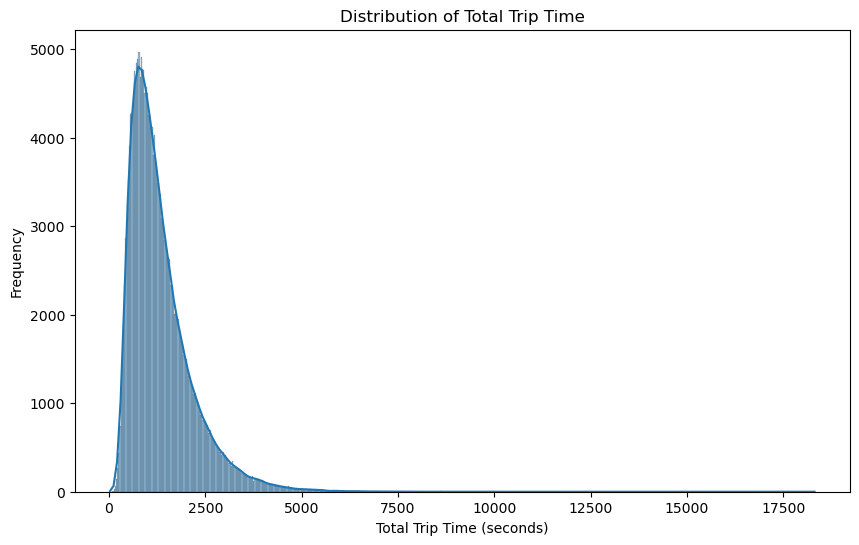

In [39]:
# Distribution of total_trip_time
plt.figure(figsize=(10, 6))
sns.histplot(trips['total_trip_time'], kde=True)
plt.title('Distribution of Total Trip Time')
plt.xlabel('Total Trip Time (seconds)')
plt.ylabel('Frequency')
plt.show()

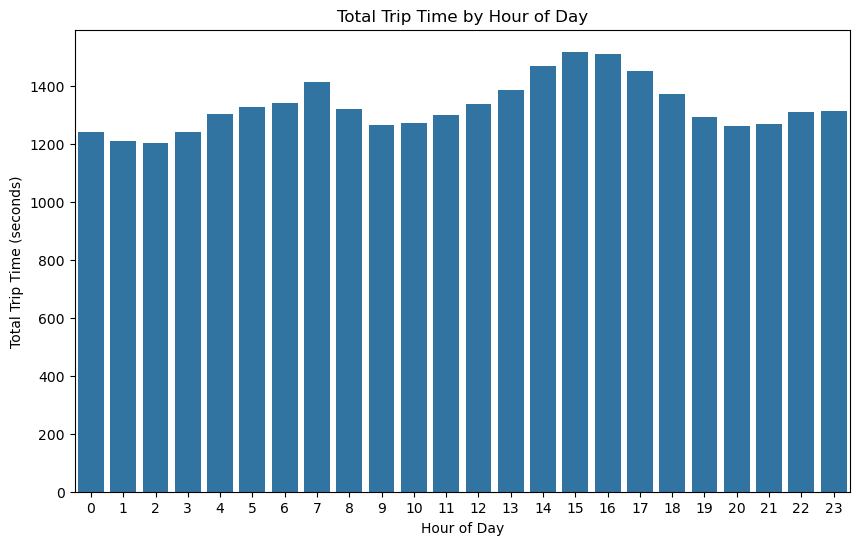

In [40]:
# total_trip_time by hour
plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='total_trip_time', data=trips, errorbar=None)
plt.title('Total Trip Time by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

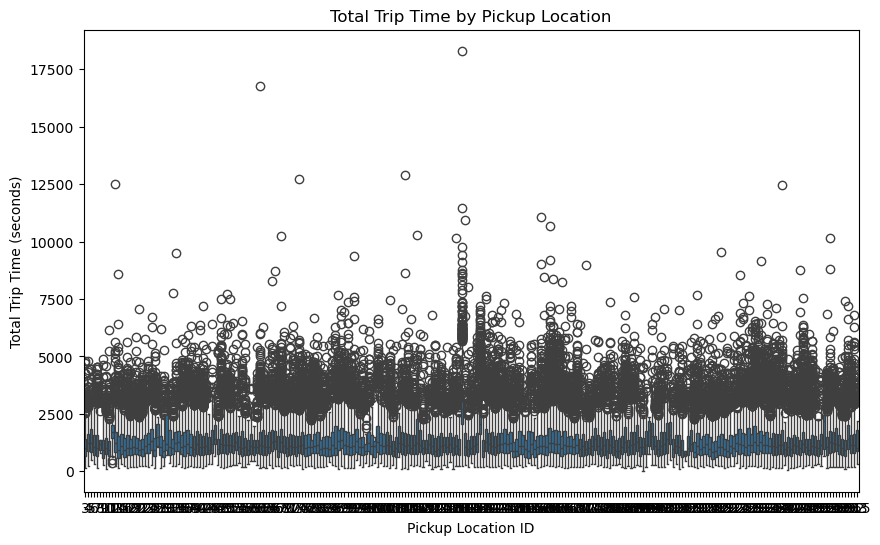

In [41]:
# total_trip_time by PULocationID
plt.figure(figsize=(10, 6))
sns.boxplot(x='PULocationID', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Pickup Location')
plt.xlabel('Pickup Location ID')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

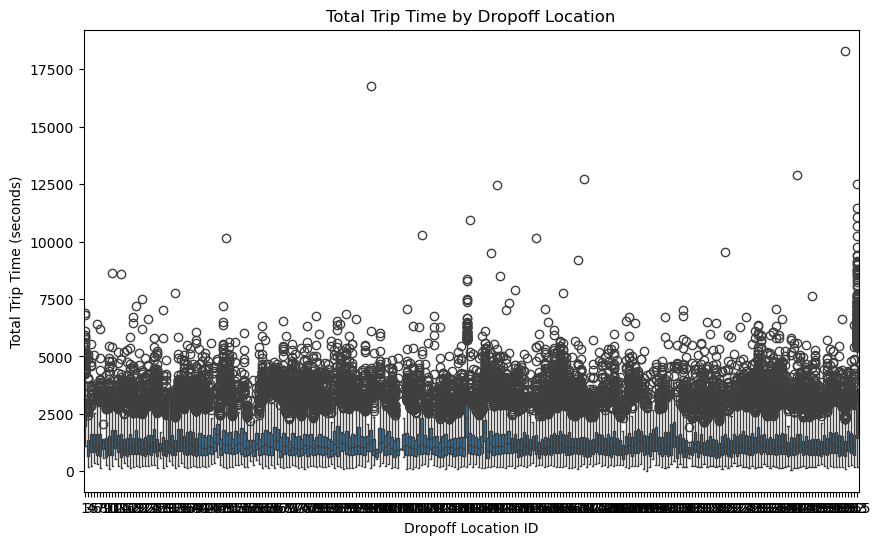

In [42]:
# total_trip_time by DOLocationID
plt.figure(figsize=(10, 6))
sns.boxplot(x='DOLocationID', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Dropoff Location')
plt.xlabel('Dropoff Location ID')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

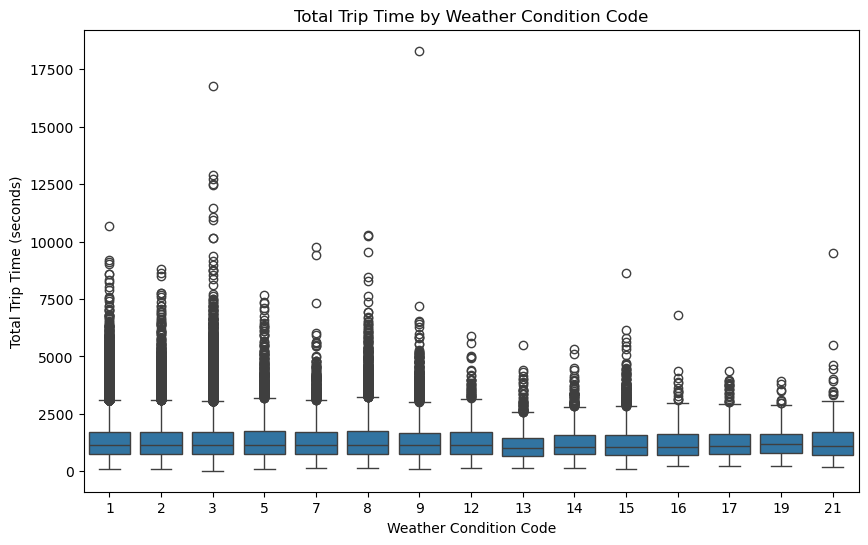

In [43]:
# Box plot of total_trip_time by weather_condition_code
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_condition_code', y='total_trip_time', data=trips)
plt.title('Total Trip Time by Weather Condition Code')
plt.xlabel('Weather Condition Code')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

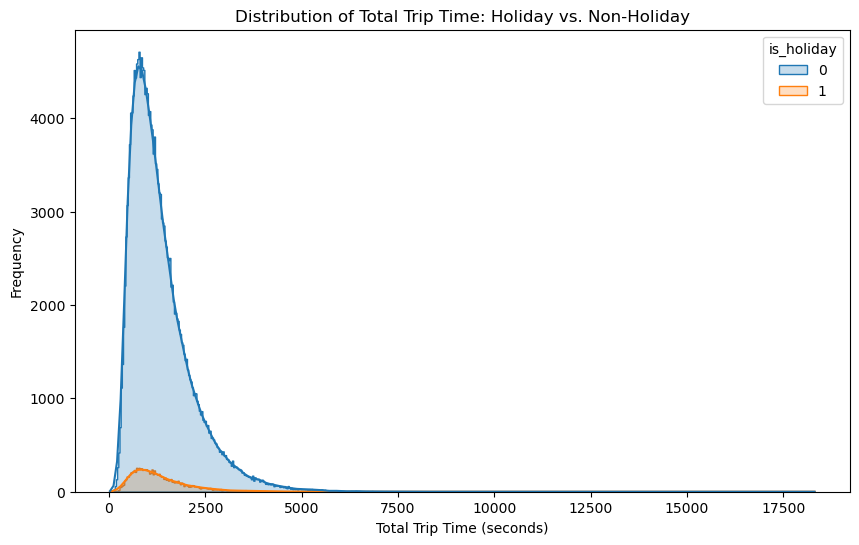

In [44]:
# Distribution of total_trip_time on holidays vs. non-holidays
plt.figure(figsize=(10, 6))
sns.histplot(data=trips, x='total_trip_time', hue='is_holiday', kde=True, element='step')
plt.title('Distribution of Total Trip Time: Holiday vs. Non-Holiday')
plt.xlabel('Total Trip Time (seconds)')
plt.ylabel('Frequency')
plt.show()

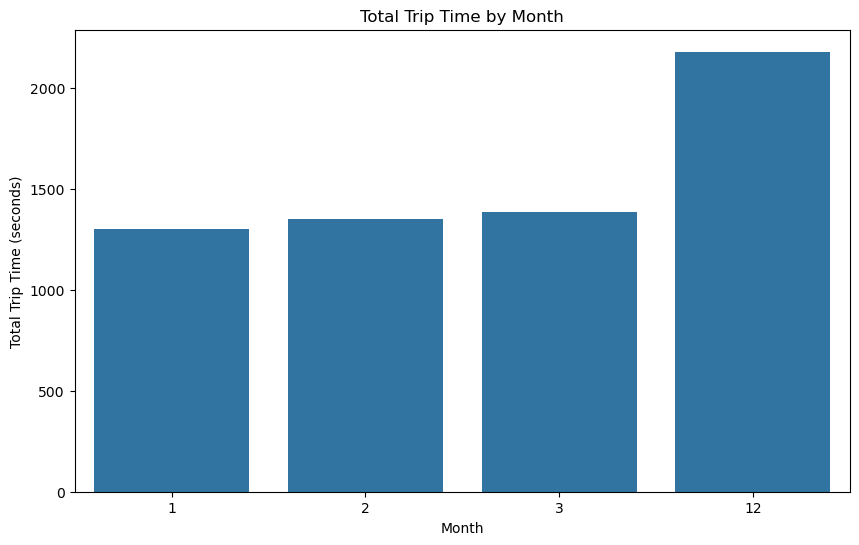

In [45]:
#analyze how the total_trip_time changes across different months, which might reveal seasonal patterns
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_trip_time', data=trips, errorbar=None)
plt.title('Total Trip Time by Month')
plt.xlabel('Month')
plt.ylabel('Total Trip Time (seconds)')
plt.show()

#### 4.2 Selecting important features

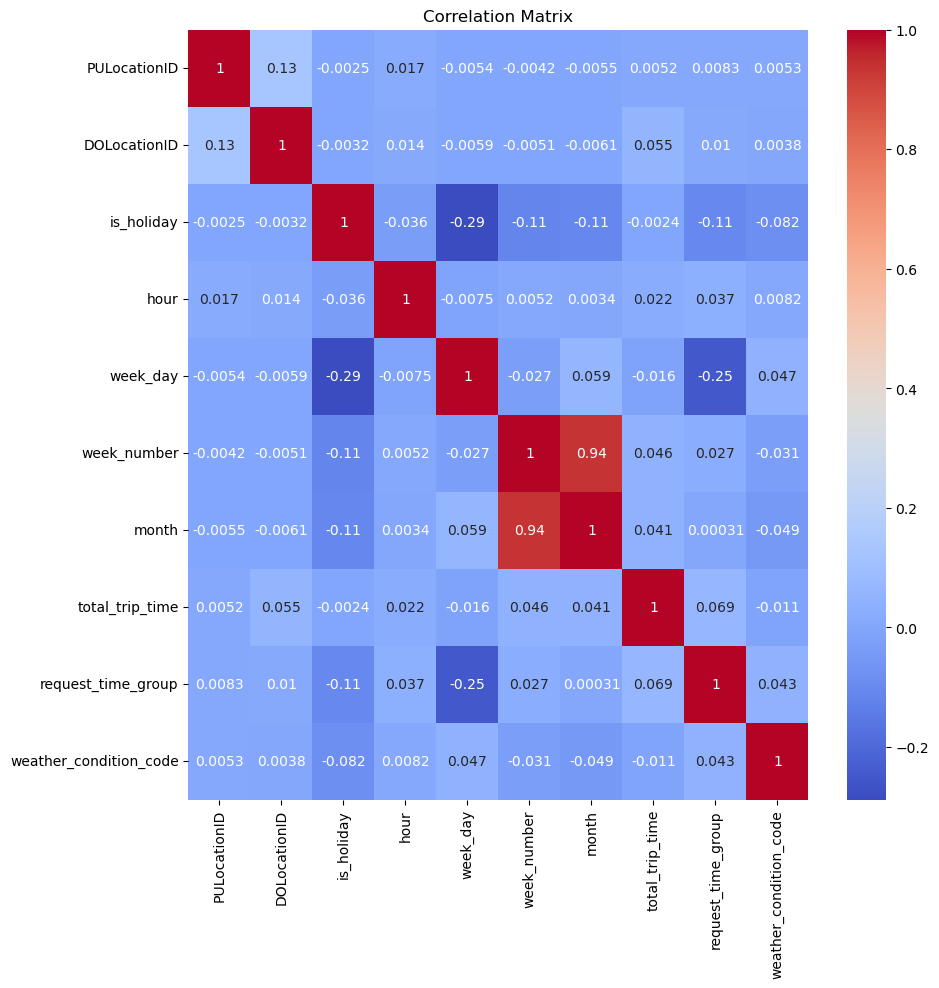

In [46]:
#correlation heatmap, to check correlation between different variables
#results range from -1 to 1 where 1 is perfect correlation and -1 is perfect negative correlation
correlation_matrix = trips.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [47]:
del correlation_matrix,end,hour,is_holiday,location,ny_holidays,ny_holidays_df,off_peak_mask,peak_mask,start,trip_feb,trip_jan,trip_mar,weather_data,week_day,weekday_mask,weekend_mask
gc.collect()

148014

#### 4.3 Feature Importance

In [48]:
# Define features and target
X_columns = trips.drop('total_trip_time', axis=1)
X = X_columns.values
y = trips['total_trip_time']

In [49]:
# Run a Tree-based estimators
dtc = DecisionTreeClassifier(random_state=15, criterion  = 'entropy', max_depth = 10)
dtc.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [50]:
# Calculating Feature Importance
for i, column in enumerate(X_columns):
    print('Importance of feature {}:, {:.3f}'.format(column, dtc.feature_importances_[i]))
    
    final_importance = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dtc.feature_importances_[i]]})
    
    try:
        final_final_importance = pd.concat([final_final_importance,final_importance], ignore_index = True)
    except:
        final_final_importance = final_importance
        
        
# Ordering the data
final_final_importance = final_final_importance.sort_values('Feature Importance Score', ascending = False).reset_index()            
final_final_importance

Importance of feature PULocationID:, 0.295
Importance of feature DOLocationID:, 0.272
Importance of feature is_holiday:, 0.000
Importance of feature hour:, 0.164
Importance of feature week_day:, 0.082
Importance of feature week_number:, 0.106
Importance of feature month:, 0.011
Importance of feature request_time_group:, 0.015
Importance of feature weather_condition_code:, 0.054


,index,Variable,Feature Importance Score
0,0,PULocationID,0.294993
1,1,DOLocationID,0.272486
2,3,hour,0.164285
3,5,week_number,0.105786
4,4,week_day,0.082164
5,8,weather_condition_code,0.054366
6,7,request_time_group,0.014831
7,6,month,0.011012
8,2,is_holiday,0.000076


### 5.0 Machine Learning Models

In [51]:
""" 
From the correlation Matrix, there is a low correlation/weak linear relationship between total_trip_time and the other variables. 
This suggest the use of complex models to capture the non-linear relationship.

Starting with a simple linear regression model, even though the correlation is low, the model is able to give a baseline comparison.
Initial focus will be on important features
"""

# Select only the high-importance features
X_high_importance = trips[['PULocationID', 'DOLocationID', 'hour', 'week_day', 'week_number']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_high_importance, y, test_size=0.2, random_state=42)

# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

print('the high-importance features')

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Model name: ', name)
    print('Accuracy  on test dataset: ', model.score(X_test, y_test) )
    print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print('MAE  on test dataset: ', mean_absolute_error(y_test, model.predict(X_test)))
    pickle.dump(model, open(name + '_high_imp.pkl', 'wb'))


the high-importance features
Model name:  Linear Regression
Accuracy  on test dataset:  0.00563583576693838
RMSE  on test dataset:  838.7399946128746
MAE  on test dataset:  615.4406635789136
Model name:  Random Forest
Accuracy  on test dataset:  0.41426851800889597
RMSE  on test dataset:  643.7302292456363
MAE  on test dataset:  443.55831913936834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 174857, number of used features: 5
[LightGBM] [Info] Start training from score 1344.129689
Model name:  LightGBM
Accuracy  on test dataset:  0.3123431103168851
RMSE  on test dataset:  697.49406984443
MAE  on test dataset:  504.22137016818147
Model name:  XGBoost
Accuracy  on test dataset:  0.39752001903164724
RMSE  on test dataset:

In [53]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_columns, y, test_size=0.2, random_state=42)

# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

print('all features')

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Model name: ', name)
    print('Accuracy  on test dataset: ', model.score(X_test, y_test) )
    print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print('MAE  on test dataset: ', mean_absolute_error(y_test, model.predict(X_test)))
    pickle.dump(model, open(name + '_all.pkl', 'wb'))

all features
Model name:  Linear Regression
Accuracy  on test dataset:  0.010134038415422375
RMSE  on test dataset:  836.8407412728765
MAE  on test dataset:  615.3073347543732
Model name:  Random Forest
Accuracy  on test dataset:  0.40110511892970013
RMSE  on test dataset:  650.9234547788907
MAE  on test dataset:  452.52282057673347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 174857, number of used features: 9
[LightGBM] [Info] Start training from score 1344.129689
Model name:  LightGBM
Accuracy  on test dataset:  0.31228286171534325
RMSE  on test dataset:  697.5246244149632
MAE  on test dataset:  503.3156920287566
Model name:  XGBoost
Accuracy  on test dataset:  0.3972015554211208
RMSE  on test dataset:  653.04135073

##### 5.1 Optimising Random Forest

In [55]:
# Random Forest Regression with RandomizedSearchCV

rf_model = RandomForestRegressor(max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)

# Hyperparameter tuning with RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200],        # Range of trees in the forest
    'max_depth': [5, 10, 20, None],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
}

# Randomized search with fewer iterations (e.g., 10 iterations)
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_distributions, 
    n_iter=10,  # Number of different combinations to try
    cv=3,       # Number of cross-validation folds
    scoring='neg_mean_squared_error', 
    verbose=1,  # Prints progress messages
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test)

print('Accuracy  on test dataset: ', best_rf.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, best_rf.predict(X_test)))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy  on test dataset:  0.38594398314866263
RMSE  on test dataset:  659.1110852100412
MAE  on test dataset:  462.6279598503255


In [56]:
# Random Forest Regression with GridSearchCV, limited hyperparameters
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# # Evaluate the model
print('Accuracy  on test dataset: ', best_rf.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, best_rf.predict(X_test)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Accuracy  on test dataset:  0.260131213607511
RMSE  on test dataset:  723.4890677276194
MAE  on test dataset:  528.9974207898863


In [57]:
# Random Forest Regression with GridSearchCV, extended hyperparameters

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model
print('Accuracy  on test dataset: ', best_rf.score(X_test, y_test) )
print('RMSE  on test dataset: ', np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test))))
print('MAE  on test dataset: ', mean_absolute_error(y_test, best_rf.predict(X_test)))


Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: 

In [ ]:
# optimizing XGBoost Regressor
params = { 'max_depth': [3,6,9,12],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

# Training the model on best parameters
xgbr = xgb.XGBRegressor(seed = 20, colsample_bytree = 0.7, learning_rate= 0.1, max_depth=12, n_estimators=500)
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_train)

# Model Accuracy on testing dataset
print('The Accuracy  on the testing dataset is: ', xgbr.score(X_test, y_test) )
print('The RMSE  on the testing dataset is: ',np.sqrt(mean_squared_error(y_test,xgbr.predict(X_test))))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test,xgbr.predict(X_test)))